In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import quadrotor




## Following a trajectory using linearized dynamics



In [2]:
# Initializing all the reqired variables
robot = quadrotor.Quadrotor()
m = robot.mass 
I = robot.inertia
r = robot.length
g = robot.g
dt = robot.dt 
ns = robot.ns 
nu = robot.nu 


9.81

In [39]:
def get_linearization(robot, z, u):
    
    A = np.eye(ns,ns)
    A[0,1] = dt
    A[1,4] = -dt*((u[0]+u[1])/m)
    A[2,3] = dt
    A[4,5] = dt

    B = np.zeros((ns,nu))
    B[3] = [dt/m,dt/m]
    B[5] = [r*dt/I, -r*dt/I]
    
    return A,B


# Ricatti equation

def solve_LQR_trajectory(Q, R, z_star, u_star, N):
    '''
    A, B, Q and R are the matrices defining the OC problem
    x_bar is the trajectory of desired states of size dim(x) x (N+1)
    N is the horizon length
    
    The function returns 1) a list of gains of length N and 
    2) a list of feedforward controls of length N
    '''
    K_gains = []
    k_feedforward = []
    Pn = Q
    pN = -1*(Q.dot(z_star[:,N]))

    for i in range(N):
        A,B = get_linearization(robot, z_star[:,N-i-1], u_star[:,N-1-i])
        
        
        K = (((-1*(np.linalg.inv(R + ((B.T).dot(Pn)).dot(B)))).dot(B.T)).dot(Pn)).dot(A)
        P = Q + ((A.T).dot(Pn)).dot(A) + (((A.T).dot(Pn)).dot(B)).dot(K)
        k = (((-1*(np.linalg.inv(R + ((B.T).dot(Pn)).dot(B)))).dot(B.T)).dot(pN))
        p = -1*(Q.dot(z_star[:,N-1-i])) + ((A.T).dot(pN)) + (((A.T).dot(Pn)).dot(B)).dot(k)
        Pn = P
        pN = p
        
        K_gains.append(K)
        k_feedforward.append(k)
        
    return K_gains[::-1], k_feedforward[::-1]


In [40]:
def controller(state,i):
    
    u = K_gains[i] @ (state) - K_gains[i] @ (z_star[:,i]) + k_feed[i]
    u = u - u_star[:,i]
    
    return u
    

In [41]:
# finding z star and u star
N = 1000
t = np.arange(0.,10.01, dt) 
z_star = np.zeros((6,1001))
u_star = np.zeros((2,1000))
b = np.pi/5
ra = 0.5

for i in range(len(t)-1):
    z_star[:,i] = [ra*np.cos(b*t[i]), -ra*b*np.sin(b*t[i]),ra*np.sin(b*t[i]), ra*b*np.cos(b*t[i]), 0., b]
    u_star[:,i] = [0.5*m*g - ra*m*b*b*r*np.sin(b*t[i]), 0.5*m*g - ra*m*b*b*r*np.sin(b*t[i])]
z_star[:,len(t)-1] = [ra*np.cos(b*t[len(t)-1]), -ra*b*np.sin(b*t[len(t)-1]), ra*np.sin(b*t[len(t)-1]), ra*b*np.cos(b*t[len(t)-1]), 0., b]



In [42]:
(z_star[:,500].T).shape
x = np.array([1,2,3])
x 

array([1, 2, 3])

In [43]:
# we can now simulate for a given number of time steps - here we do 10 seconds
Q = np.diag([1000, 1, 1000, 1, 1000, 1])
R = np.eye(nu) * 0.001
K_gains, k_feed = solve_LQR_trajectory(Q, R, z_star, u_star, N)
horizon_length = 1000
z0 = z_star[:,0]*2
t, state, u = robot.simulate(z0, controller, horizon_length, disturbance = False)

<IPython.core.display.Javascript object>


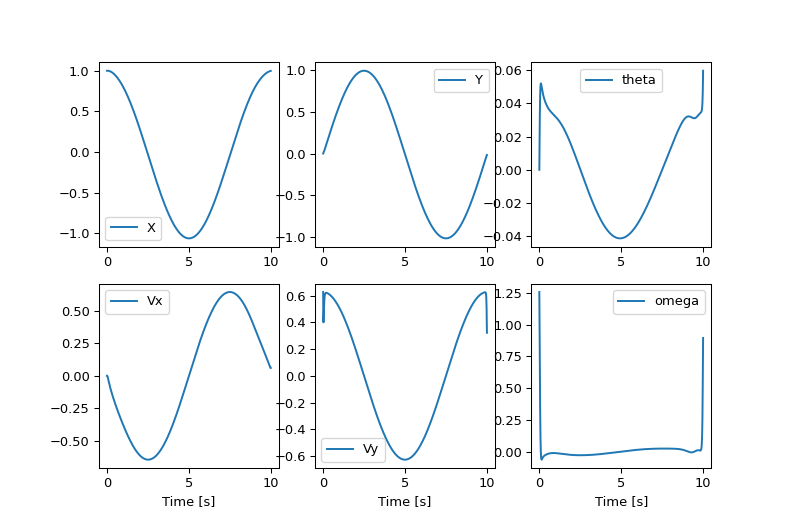

<IPython.core.display.Javascript object>


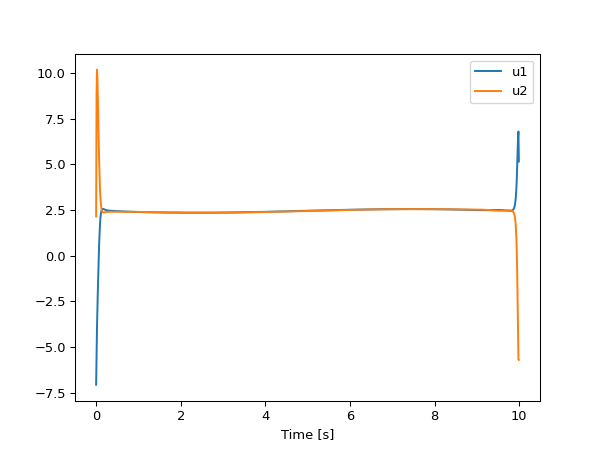

Text(0.5, 0, 'Time [s]')

In [32]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

In [33]:
# now we can also create an animation
robot.animate_robot(state, u)


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXkxtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhy
ZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABJYZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAAAwAAt4AXsAwgCqgMKj6I
dndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G73ihHZi4T1K1iog5Wc0p6
pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ6vuZEf6FCWPekrjf3iOx
g9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlxb1HUXmuG+fEgDCAJNggr
SWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7LdbaaCmFlaKG6p3WlZZBOgL
c6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlIHYXCzI57hN1GXk5AJs78
kL3L0uFd6c/RFa7OFV/kuFKHj+kqM4DkzP7PBgAC6AAADAn+uXo8j5J0TvKiQM4nLDD+XAg9NeD6
W8cce2l/FR62IVTJaZmpZXtWP3P3BP8Aty1kv38ceunYStFyA/05L8hPnpct8GwCWlzTtbCvTReE
HJz1a5gtpTABNPy+/tCuvMR6WgJvSsNn61ezHOjGNwqbjeiH0YSDdQMKznomzDwO9Guv8vX0Axnn
UksKqHboJ5g5oIo877MWl4BrV0RlKw0IFwXY/uC1/NrVms+YIRkAbT20GeVQYPen6zGAVf2KCyuv
i/o7vB46nPxSm/qMgeMjM/laohkgNM0SBaFCXrzNuC+3snatr9vBmkzqlolCtOpEXoijNRPf2sX0
Sg8AuZkqAHN/k60MTNXn1Sra7J2rdNwCn6l/5a8jeEBwuzeTuyDMFytRDj+ei/wYryU00dNQJ4KR
pnFfiJuXJ8LyOU832g9SwiY/rim8AAADAAADAAADAAAJUchT685ptYvFSJ5vRPBnShcaoVlbv1fv
nAdJyQ9/h4Y2MNTtxdM5/2ubtKfAQmv/f4fxiuVos5NHnHCOA54iXCHkF2+KCSvxjH837gD8r5Lg
vudrJ1j54JkDGsG6y6lnuNxvCAHUYC1dFOeeXj/OnDH3oRVc0spfxoKmrdjIb21n9P9d7r4TN8Ob
HE4fjwmtp43o4qyugzEbdTaOF22JNee+dRYXAayjEWwaPQmq8hmvqUMjwJs3aGt3ALm+CrSl9T5E
yKbw2ErxZBytHO+1/8hqthoH2mJIBqiCSA3Tc3rB/5FaTBrknzyEbXMuyUY/6kdM/z2vNwUquAPk
8XEAxFgacBdsgG2GFtDMYAY8/0fs4L8Z204YrgqedjfPsHcmd+kYEcaLegD5YX9qgAAB4Db/CAAP
aKxckAGkxOxwAqZjkRHr6sqHKLkLbhvTk9IUHw+TSCCiGYjFxmH7GWAoNFjyaUKodLvESboABE4T
Z0nN+XYOql3Y0OxLmu4Ws5YZk03JudmCY9sFOl8eD1bZTEn5mdHecgtFcOccvbjhiKqbmGDolGUL
f/hmh37YrqMImNsGktimQWyTeiDxgPgoXi/wyb3dTSzhD9KL0jpZOlvOhjJ/YAsW9PM/qwaXVKA+
q32AzG61Bw7+M9SV6Dx3P8KhhwqSry5mmiaOYRdlUgM2RZadZRF0BIzTiYCVucOAU60wnq+jTlxW
donHusU17bsrroKZZntYVkC5xxp8H1sjFHWMZ/GUdbHdi3EZHH10pDl6lZX0hnNlCjrOFbI3UF0U
14TAAO3C4BDMbaD+tIyr/DmVsX2nAtiqwIxByvcaYq8T7v4vf8d0BCK8zglbajCdJL2SEchs7sv5
+gBBZIIeqehDYftlu1idvheJJAb3sQpHzodGCggXFc7ky3DwAAAHHd23Brv2UdrqACyrPuzw10Yw
1QBe845WFb1LEHLpku0k/UyibHdGf+6GaBrCr8y0rQjnWQCe16nNn7JKfgqOi6LkG9rj3PEY4m8q
2KfzAbH876DvdQ55MafuYmDa0MsSHg4kw4jdDaF+0fQbbJ/E7BXsFZ3ns43cZBoQn9R/RuBGe08+
Dlx1j/9pEVFJeZqF90VPLL2sMlU10o4V1LZlYFSUr6efdGXKvgovy7U0tPWdKk6+GJgAN8lAw5bJ
u12GiMxEitY5+fCaaXJ8mKoiB+khs9gugWC054+iHAz6IkqztgZSjn8ej+wvBer+Xh/y/3ADmsEN
GakEMRkO4hW5eJ1gx7akJsV+TdwxmNUInlk+GieG5czAKIDeB8KVdr7DfSnCBoQdBIfIltj8bWjM
NjxBYpphX+ZnHzo4+4V4hDWmWx9RtV6WOlMIuAwWYn7InhJlT5NAGE8b76BRnxa1N4jm4rKOX9SD
5JxnyOl5J1yzIO4QOmXWZk9ikTI/3s8DeBfGRw7Htc/3rmGWSv/BltFFsW09Og5ZwqmmgSZWPIvw
I77Ezz4/sIoz3G+feojCrHJ9qruiKUFOs1wyXXWFLKdh18OaQUiK8+KPb0gIe3TqIzgANXwPJ32R
S4yk5GE7DsPX4M5ANAxu13SDlqDLa1I+U9yu4CzMqRnxLi9/6lWy0dJ0As9s5XhrEZO/e8B/5r3m
IRtxb++oHN4D6icCnZV6axcsqoZl2Lo95O6+SXAObzctCtV5Xwu5CjxpeJCw5cm3coxnCkxZF3mW
iu0Ky98aB//lYvJtq8mR8WXuZNwFn2Ne8082LbdzsPNgW87v6PufkwLqhvA8wYd3pjTpoTEDay/j
lbssei2hjP/3NwTpB0RncEsPYaFjz8ax7ZjuEu6PnqNqs0lkvP8jzxA4AAADAAiO7aE5AAY5gAMv
wlrTKOcYeNCx5jotANVeIWAU3+5L2et47/8gtvvAlU4tmvmR1B/Y/aSr3jy9T5ZQCd/aCbYC+zcM
u3WK6yJer+F6Kr9MamfuH

## With Disturbances

<IPython.core.display.Javascript object>


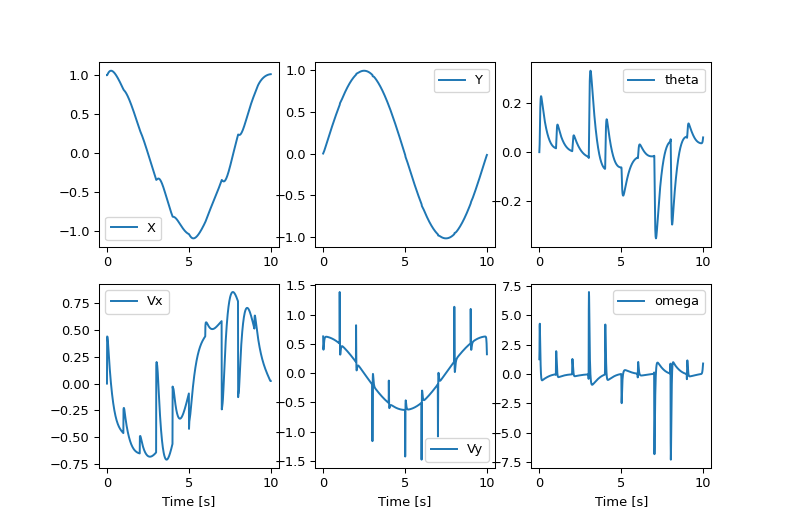

<IPython.core.display.Javascript object>


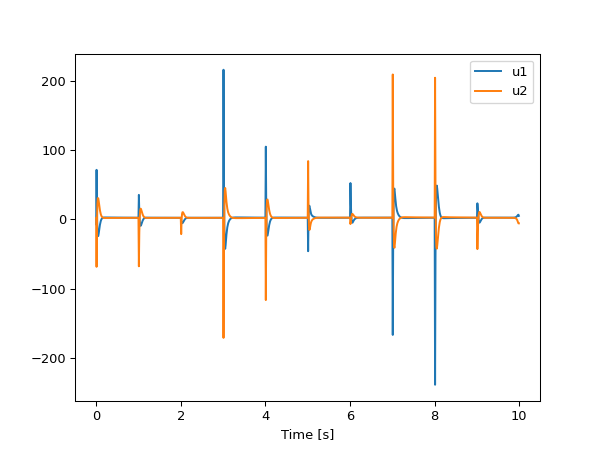

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAcRttZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xOCBsb29rYWhlYWRfdGhy
ZWFkcz0zIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABJjZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAAAwAAt4AXsAwgCqgMKj6I
dndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G73ihHZi4T1K1iog5Wc0p6
pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ6vuZEf6FCWPekrjf3iOx
g9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlxb1HUXmuG+fEgDCAJNggr
SWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7LdbaaCmFlaKG6p3WlZZBOgL
c6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlIHYXCzI57hN1GXk5AJs78
kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k6J3lRIGcTlhh/LgQemvB
9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Qnz0uW+DYBLS5p2thXpov
CDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoGFZz0TZh4HejXX+Xr6AY1
NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4Lsf3Ba/m1qzWfMEIyANp7aDPKoMHvT9ZjAKv7FBZX
Xxf0d3g8dTn4pTf1GQPGRmfytUQyQGmaJAtChL15m3Bfb2TtW1+3gzSZ1S1Rg4BH5ZPE24z39rF9
EoPALouyjq/tksmA0xnvlOq2NQQ7nQGy++HnWaMv68jeZLfIspnHkGYLlaiHH8+7/gxXkppoqbbV
zGkbOLAlUxuB3Hkcp5ozwRFJEkffYokAAAMAAAMAAAMAAAU6K2WUArTaxeJ+FAI6eDOlC41QrK3f
HaPOA6Tkh7/DwxsYaebi6Zz/tc3X0+AhNf+/w/jFcrRNyaPOOEcBzxEuEPILst0ElfjGP5v3AH5X
yXBfc7WidnYCZrsawbrLqWTm4QgoAdRgLV0U555i/86kNOiHr46Nw6torKk1r7mNtZ/T/Xe6+E7+
EjZHG90CyaEPaGS3j/5mYHg3MA5rbEmvPGuisLgNZSWC1YVoTVeDeOdKGR4E2btWR6qv3qENxUyo
8iZFN4bCV4sg7yVTfCv+Q1WwrD7TEkA1RBJAbcuHVY/8Cr9g1yT55JNil2P/LNaXYUIQw3dbuA0A
Pk8XHLIUBKF97ZANsF7aGYwAx5/lXZ4VehoU4xcE8RhlLFM4cpp+d+Knot6APk5kCQAAbt3cswf9
8VQgESJkJJAA+SWSIQAb8pg7QEFCMiI9fXlA5RchbcN6cnpCg4tPCQQUQzEYuMw5TSwFBoseTShV
DvUG8HqMeInlNnSc35dg6qXdjP7Eua7hazlhmTTc0VS9ZoYRvwPFL4tfuY06N4iDUZjIQbg7U70s
URUHGExDjY1GOP+WaHftiuowiY2wZc2zZBbJN6IPGA+CheMfDJvd1NLOEP0ozXYw03vnZs/W9gCx
b1e23z/vXgKv7enJbogTUHDv4z1gABhP1/SXYHCp6yrmaaJo5hF2VSAy/BARTeIugJGacTgcNzhw
CnWmE9X0bMVWztE5N1imvbdldcpP/z4mBhZyUL2s6A0JcW+hgu9lHWx3adxGRx9dKQ5epUP9IZzZ
QME3erdP0VHJ+REwADu7509r+b+v8kIPpRYTF+sewkxVYEO4vBmVMVeJ938Xv+O6AhHeZwSttRhO
kl6Raek49KTxM4ESzsS3uOyh3m66ddYZ5EM7tSmmTd5iqZBWUBuo34kQtRq1AAAVW8+UdG/OkF6L
JezHIA2ekRpmHoaybQGt6sA/JDe3AHElc1gmPi/DZNzu9ecET4FCU9WVOHUzJ7Xqc2fskp+Cg6Lo
uQb2uPc8RjibyrUz/MBsfzvoN91Dnkxp+5iYNrSQPPeDrzDiN1Ll37R9BtsnAMsFewVneezjdxkF
7CFwytG4EZ7Tz4OXHY/f2kRXT/+srgW4RABOLFqQsGMOPlTww6mqP+THqNw7gxRfl2ppaes6VKXZ
KEvlWpiBG29Ti8LsNDZqJFaxz8+E00ua8bmNXgOo3M9gugWC054/SN534x1mp1fEUzwM+iJKPjw6
9Xpft5N17jqKWeIaSf/DjB7VQ4qsQQxOA8iFjhIpmDHtqQm377kXDGY1QieWT4aJ4bJzMAqVCJE2
AGu/mZL8nB+RRrt24AltXSrWQAR2ooBtrCs/Bt6bo//8gBaAFInko8LRYmLhMNLsuRBz1YyQ2+dh
CTwe6o7zUSZUiqR3HS2gvm7qbiu1yETg34mKmFa/t6VV5+O2rTVX+drIo2xKUOm++DCo8cJdLyJK
W0jEizmDwA7Dy1BPN6eg9ffl9PCjla8jKYjwZYjQqNfzNalQKPg9YauGWv+9V00CIqoJS1+jghg4
o15wVGGS9vzqx90GbQ1qxSzAdqdKx10hPbuUb3AjnhPBicEodhnPfG8dwpnEGoQTY89yu4CzMqSG
JuMVmTSU0du4ObJxLKboMiGTd3vAf+h1+C2DG2TcHWYTBLD6mgcySNR5HGh32EgJi/XgRYDLdtRz
VZ/IO21J3+YZ8oZKVPrtmoT7d3t92kMh6mfukbaf/8rdFnKi+jQqS2kAvHg1bXMv3sAXDVvP9zlT
77lTRgLisg/0vxDjQBoBv62TbNWuNXx3jxE//rJApCIZAcj3YbRwoq0t0/RDSBsHf7RkgGAAC3Qn
IxNfv/gtYiagAHdgAD4Gr0sOES89bTRIGb/QLMSa7QpGf6K94Gq9Rd7+WSZpHNfi4ooxGUPz2kDe
X+xgd3ReexYjUXbzdjApo

In [9]:
# we can also simulate with perturbations
t, state, u = robot.simulate(z0,  controller, horizon_length, disturbance = True)

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

robot.animate_robot(state,u)